In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import berserk
import os
import random
from itertools import chain
from collections import Counter

In [66]:
#extract usernames as list:
with open("../data/usernames_2024-08.txt", "r") as file:
    usernames = file.read().split(",")
users_sample = random.sample(usernames, k=500)

In [67]:
api_token = os.environ.get('LICHESS_API_TOKEN')
session = berserk.TokenSession(api_token)
client = berserk.Client(session)

In [68]:
all_ratings = pd.DataFrame()
for user in users_sample:
    try:
        user_history = client.users.get_rating_history(user)
        for i in range(len(user_history)):
            game_mode_ratings = pd.DataFrame(user_history[i]["points"])
            if game_mode_ratings.shape[0] > 0:
                game_mode_ratings.insert(0, "username", user)
                game_mode_ratings['month'] += 1  # because months in lichess API start at 0 we have to increment by 1
                game_mode_ratings["mode"] = user_history[i]["name"]
                all_ratings = pd.concat([all_ratings, game_mode_ratings])
    except KeyError:
      pass
    except berserk.exceptions.ResponseError:
      pass

In [69]:
all_ratings["date"] = pd.to_datetime(all_ratings[all_ratings.columns[1:4]])
all_ratings = all_ratings.drop(labels=["year","month","day"], axis=1)

In [70]:
game_mode_frequency = Counter(chain(*map(list, all_ratings.groupby("username")["mode"].unique())))
game_mode_frequency

Counter({'Blitz': 484,
         'Rapid': 443,
         'Puzzles': 426,
         'Bullet': 405,
         'Classical': 240,
         'Correspondence': 105,
         'UltraBullet': 98,
         'Chess960': 97,
         'Crazyhouse': 84,
         'Atomic': 66,
         'Antichess': 65,
         'Three-check': 56,
         'Horde': 53,
         'King of the Hill': 46,
         'Racing Kings': 41})

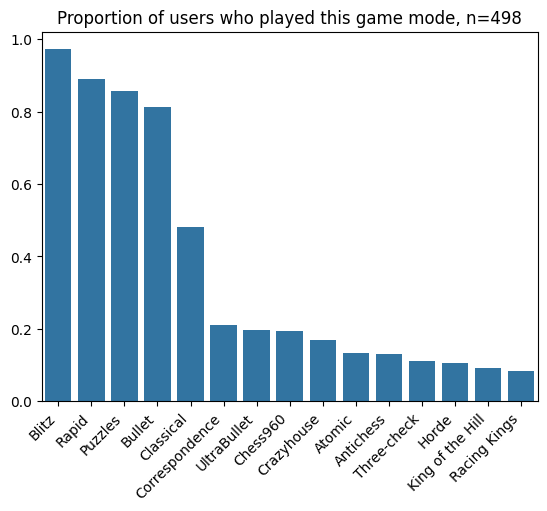

In [71]:
game_mode_frequency_desc = dict(sorted(game_mode_frequency.items(),key= lambda x: x[1], reverse=True))
n = len(all_ratings["username"].unique())
_ = sns.barplot(x=game_mode_frequency_desc.keys(),y=map(lambda x: x/n, game_mode_frequency_desc.values()))
_ = plt.xticks(rotation=45, ha="right")
_ = plt.title(f"Proportion of users who played this game mode, n={n}")

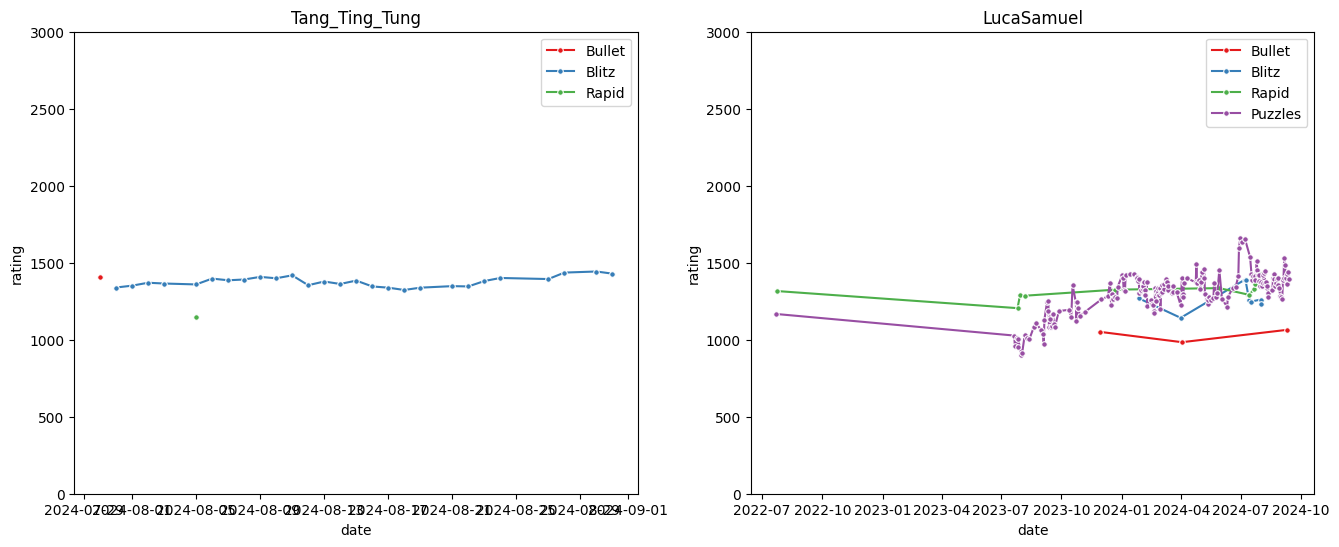

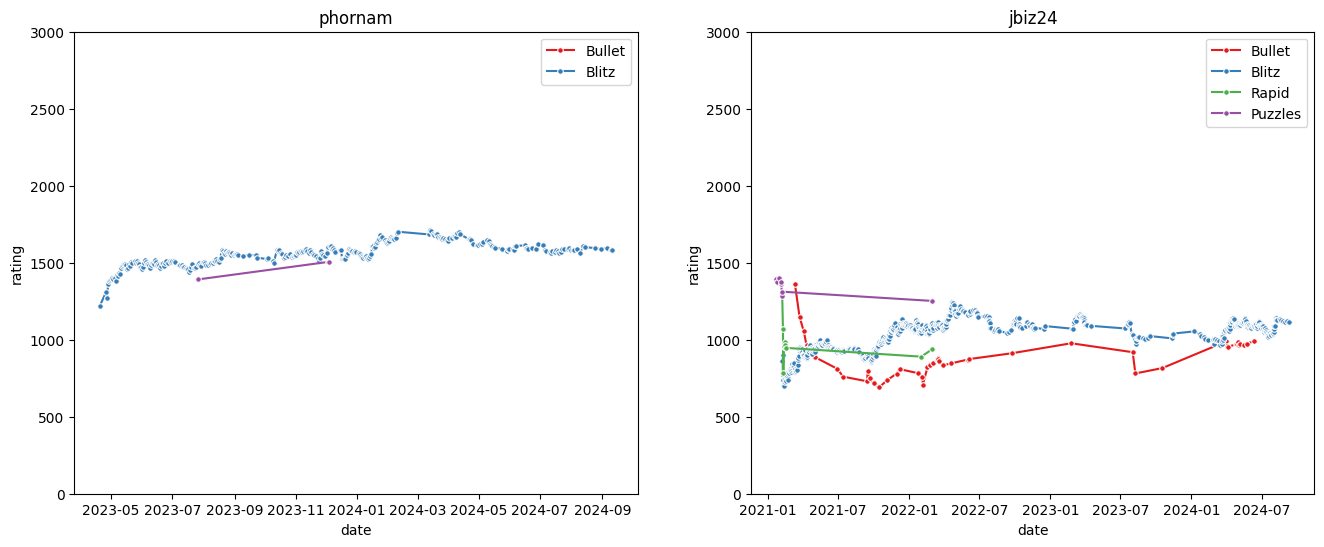

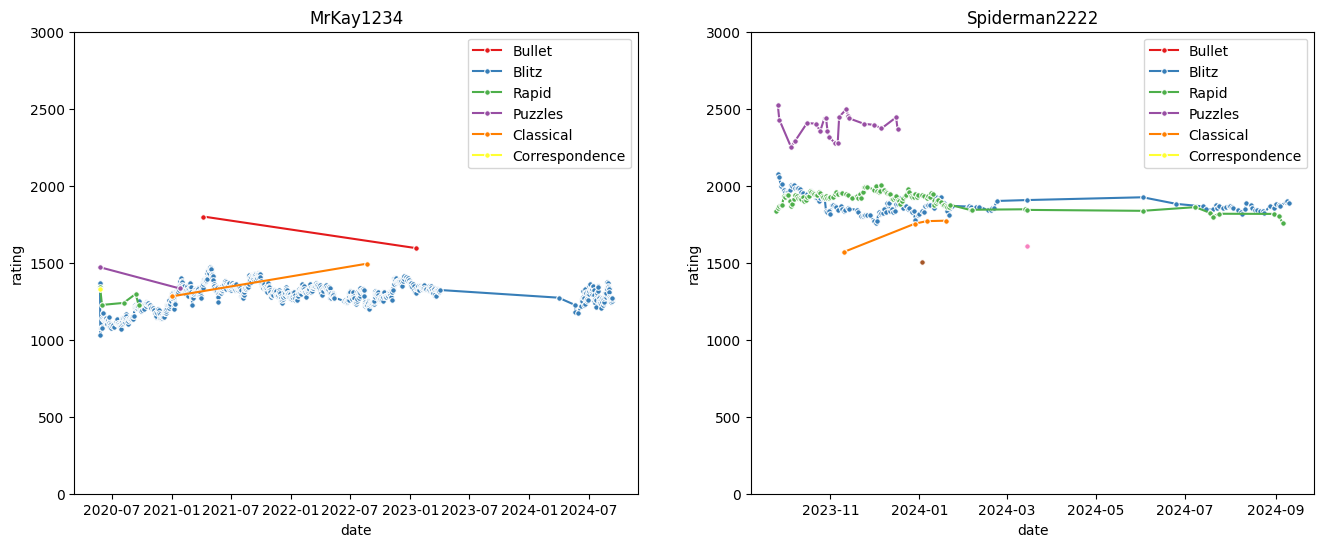

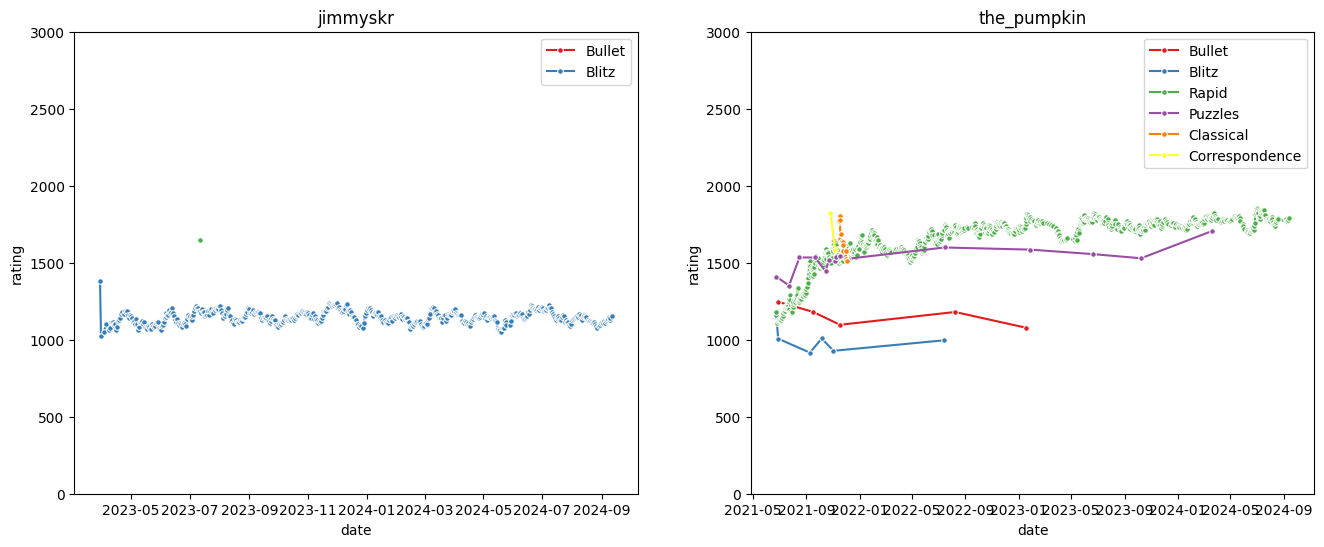

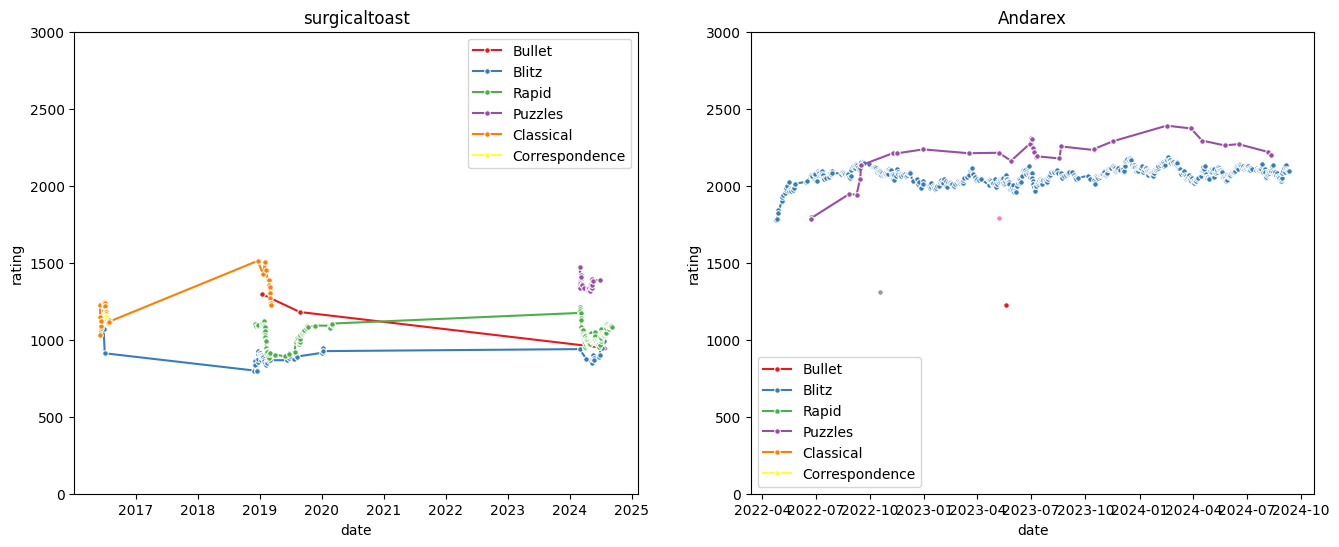

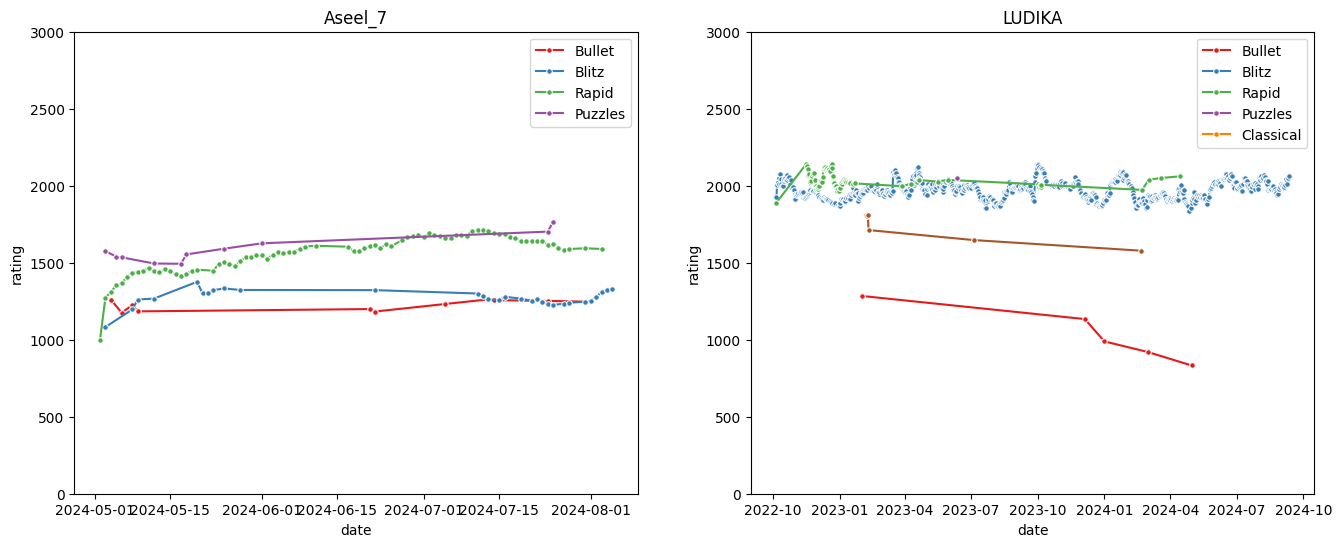

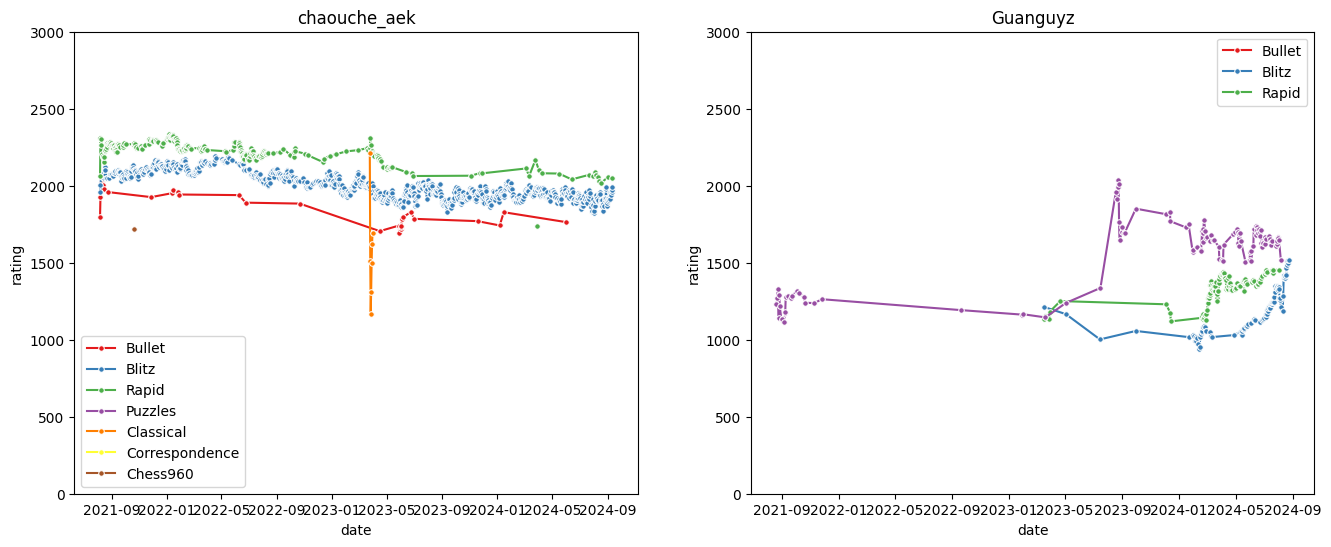

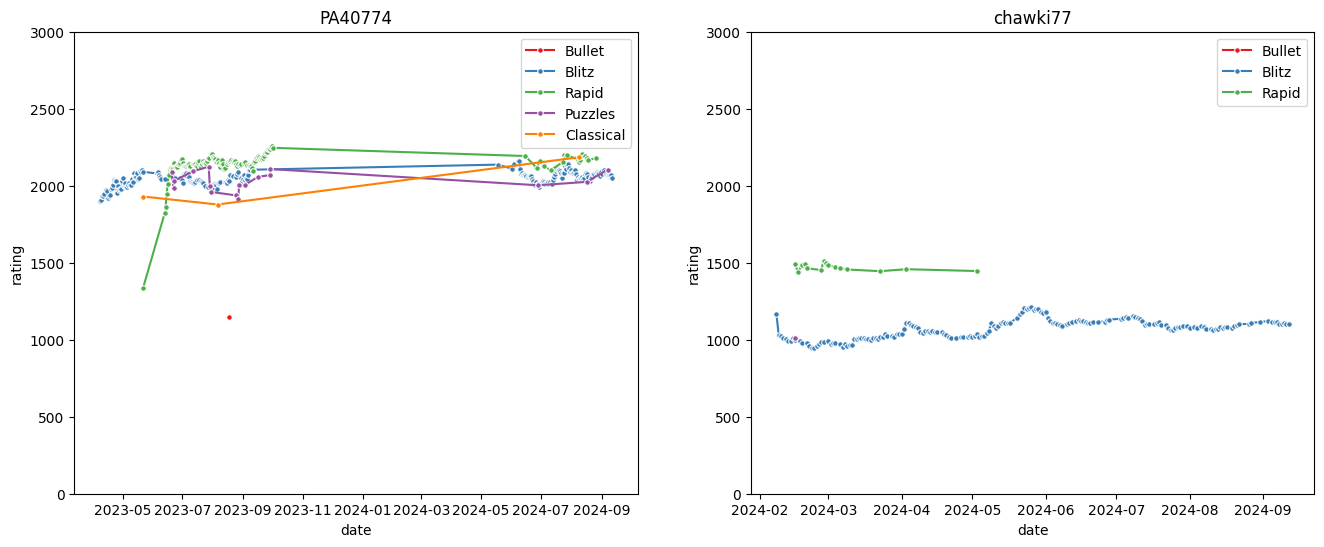

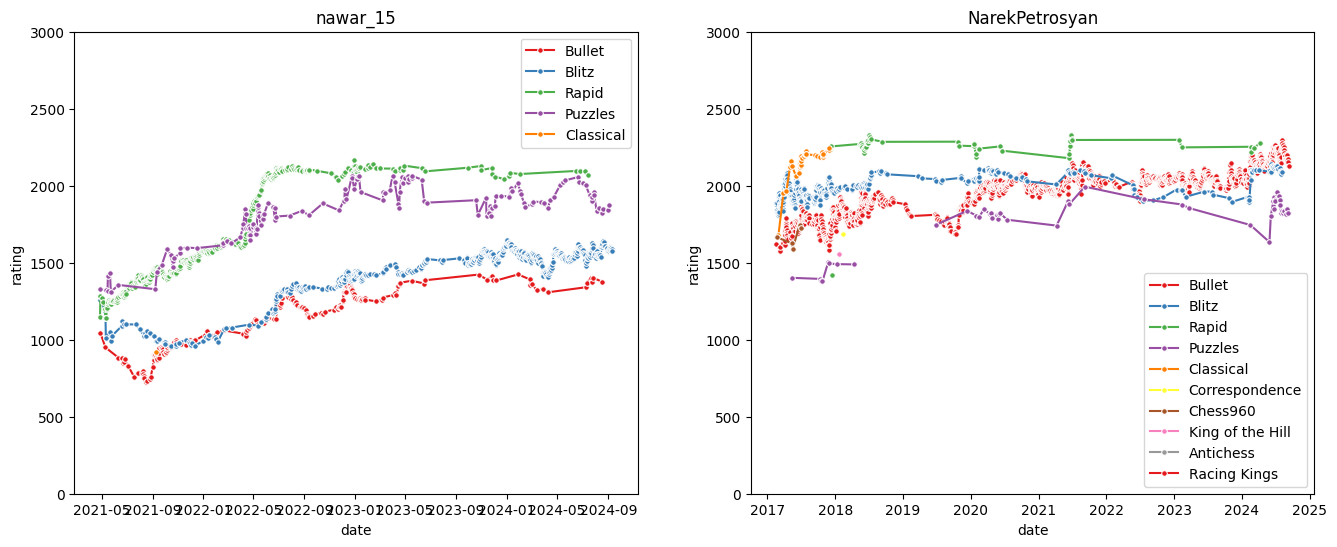

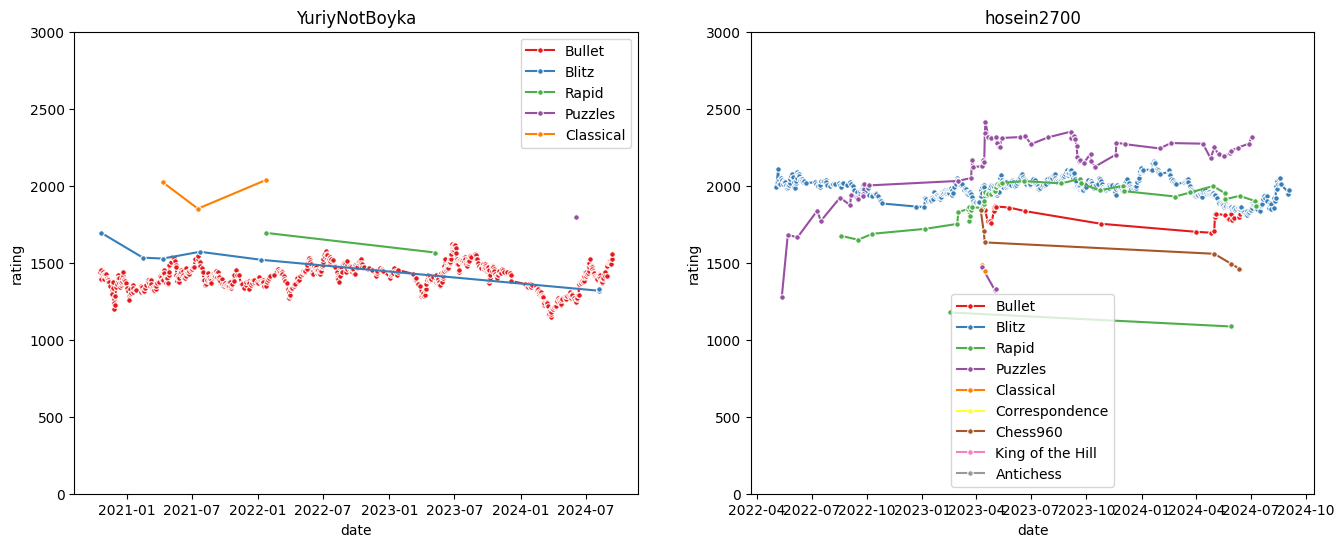

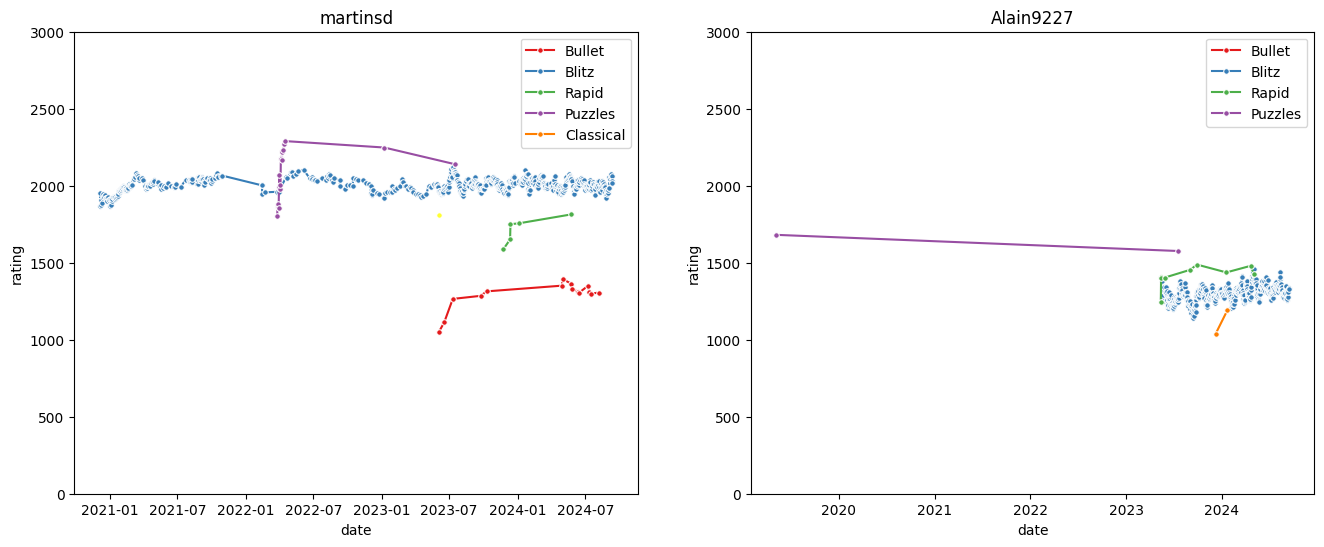

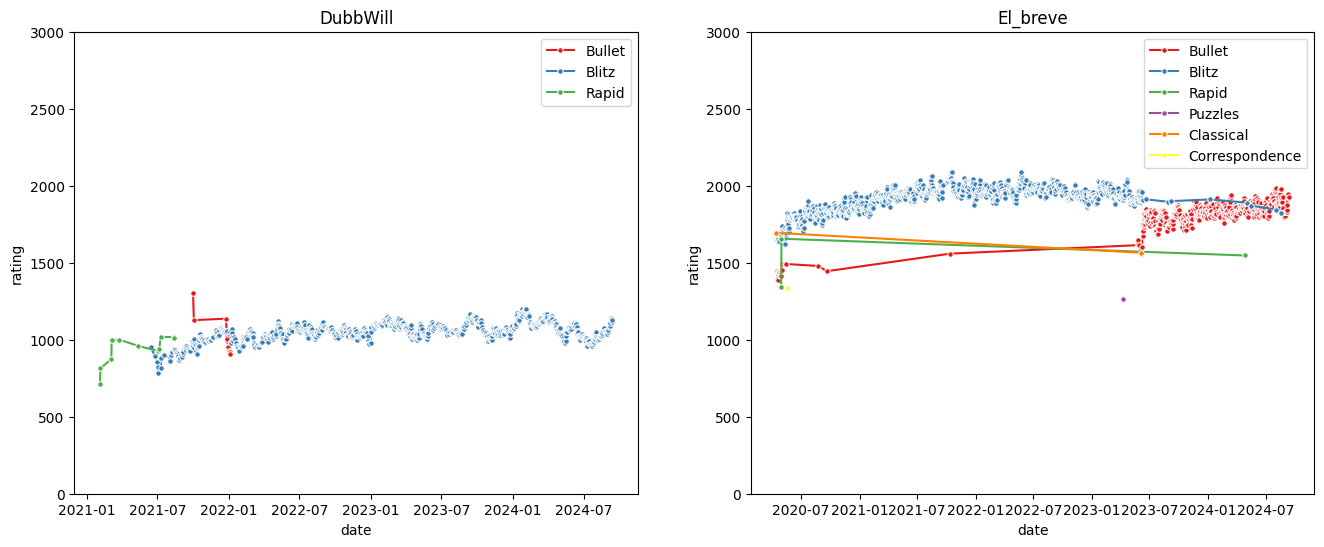

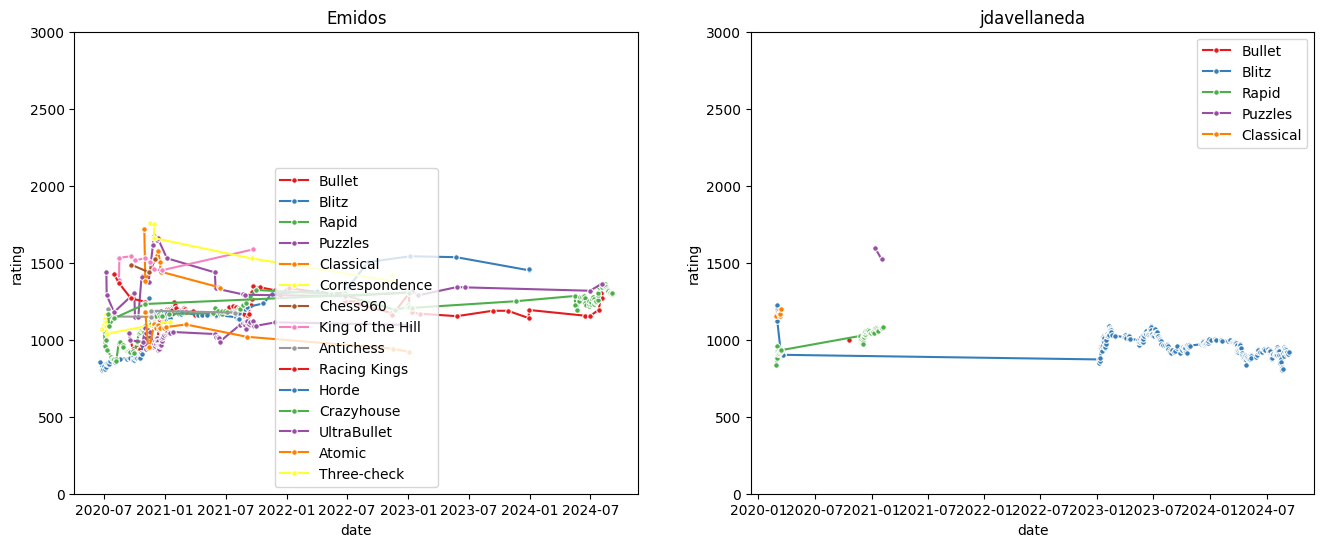

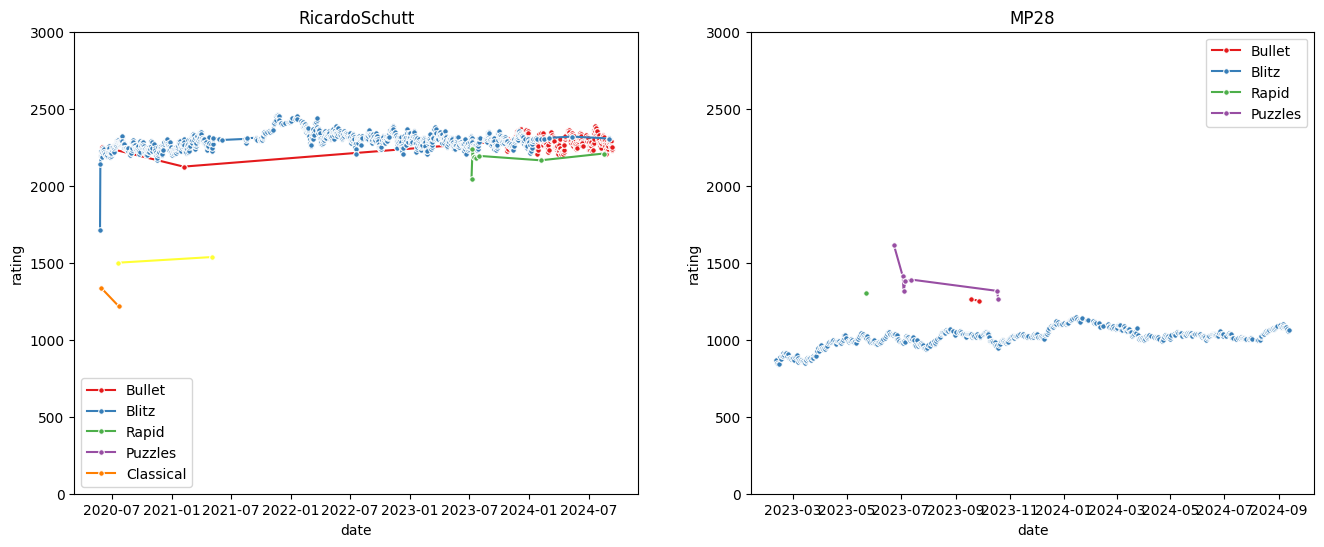

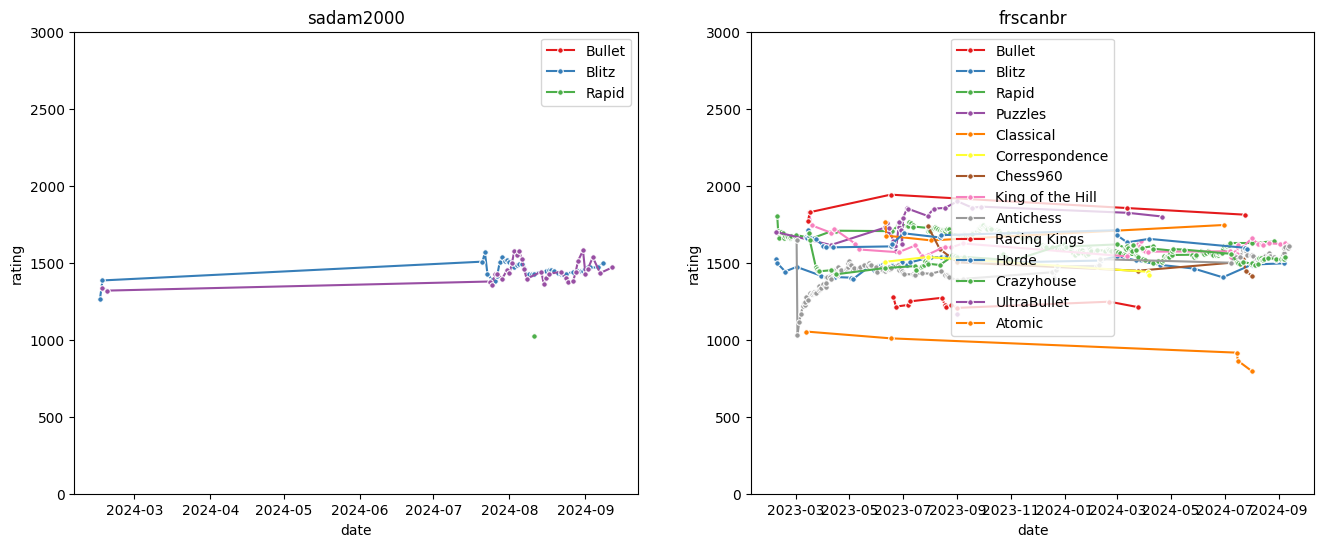

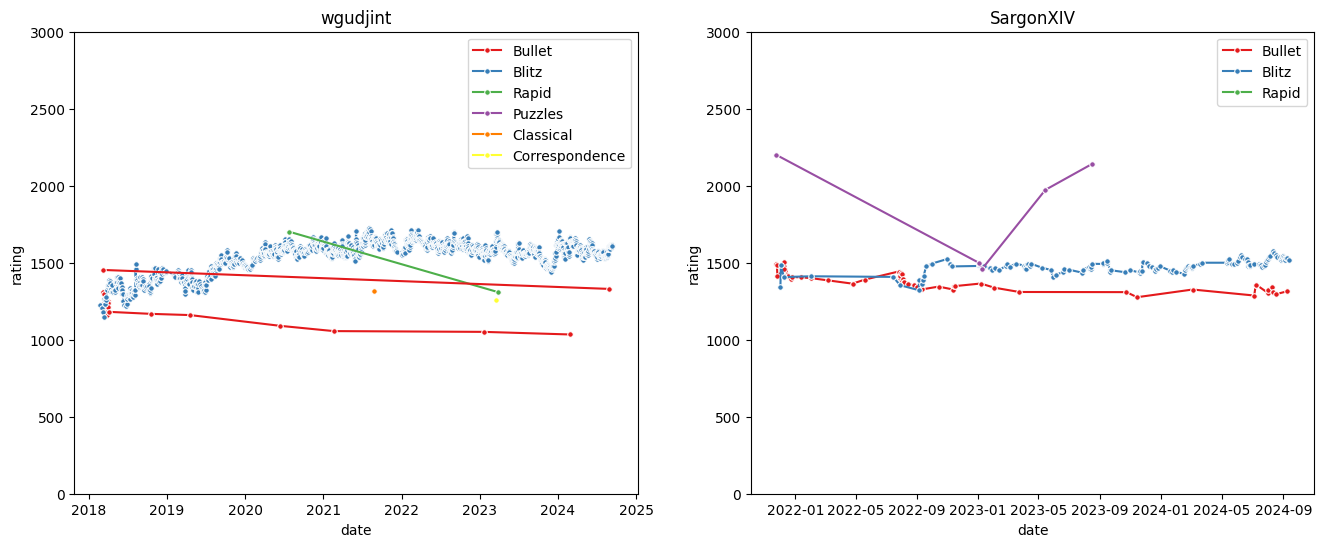

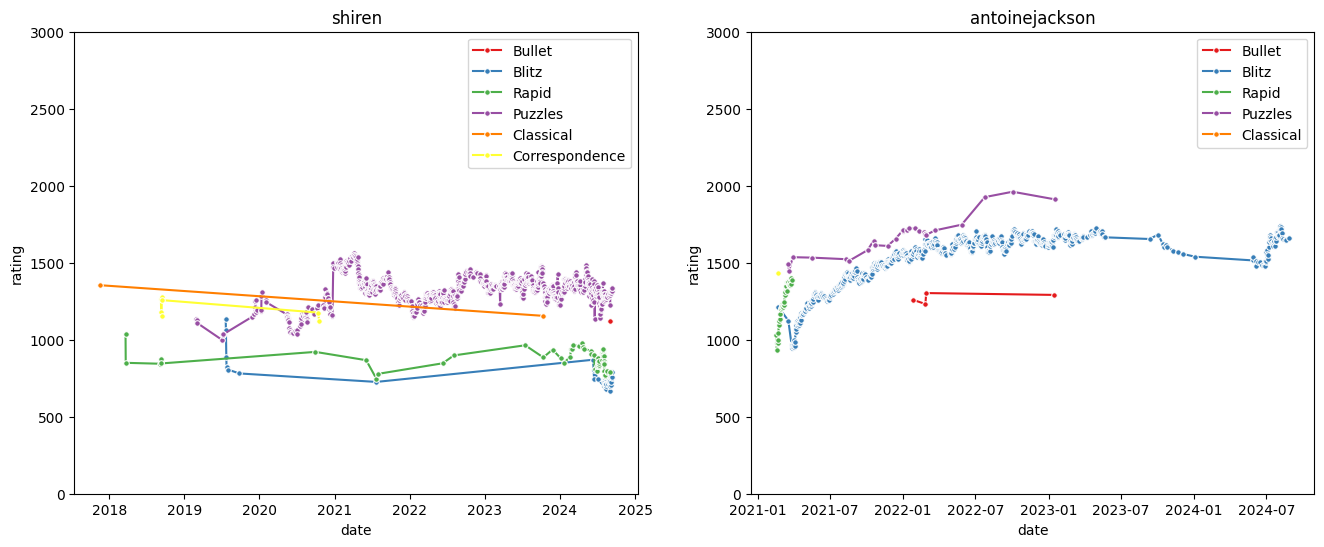

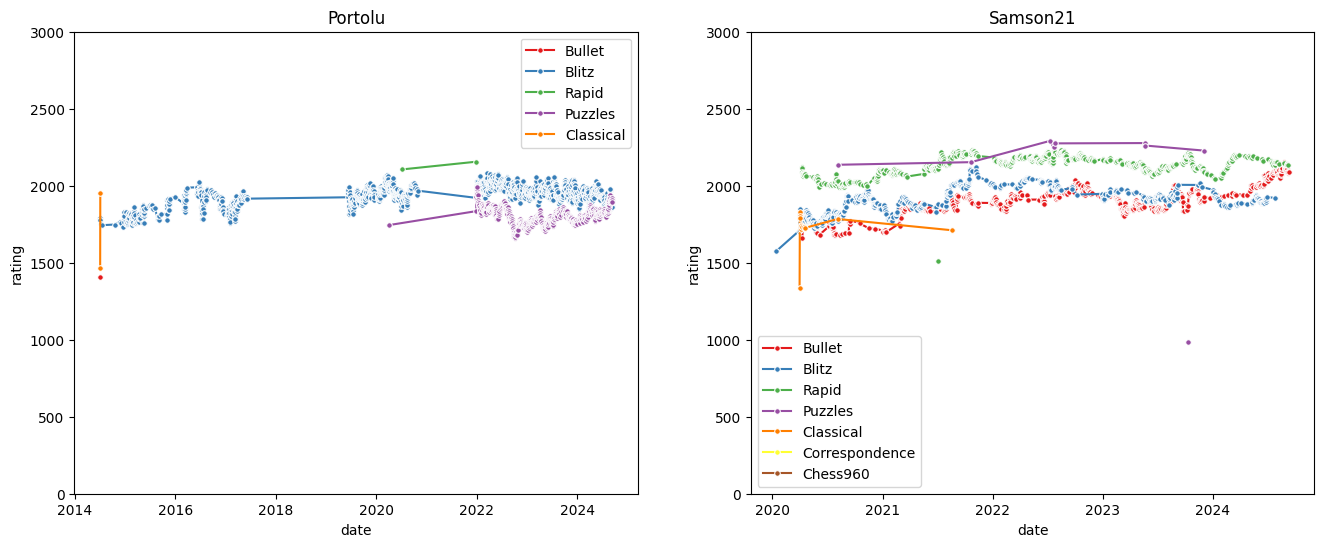

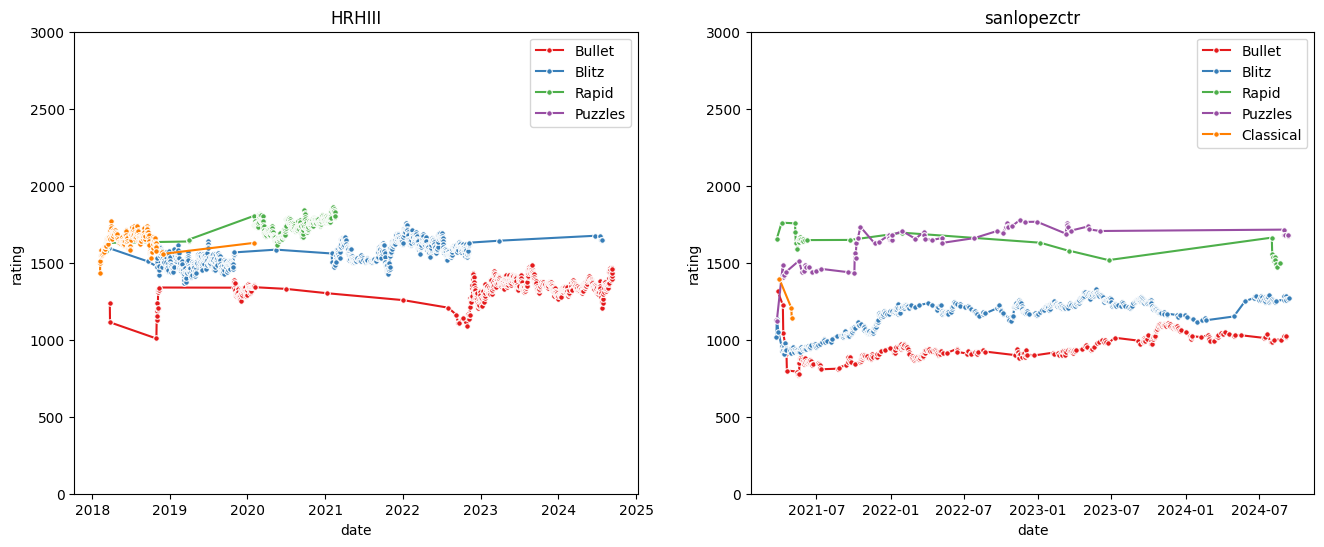

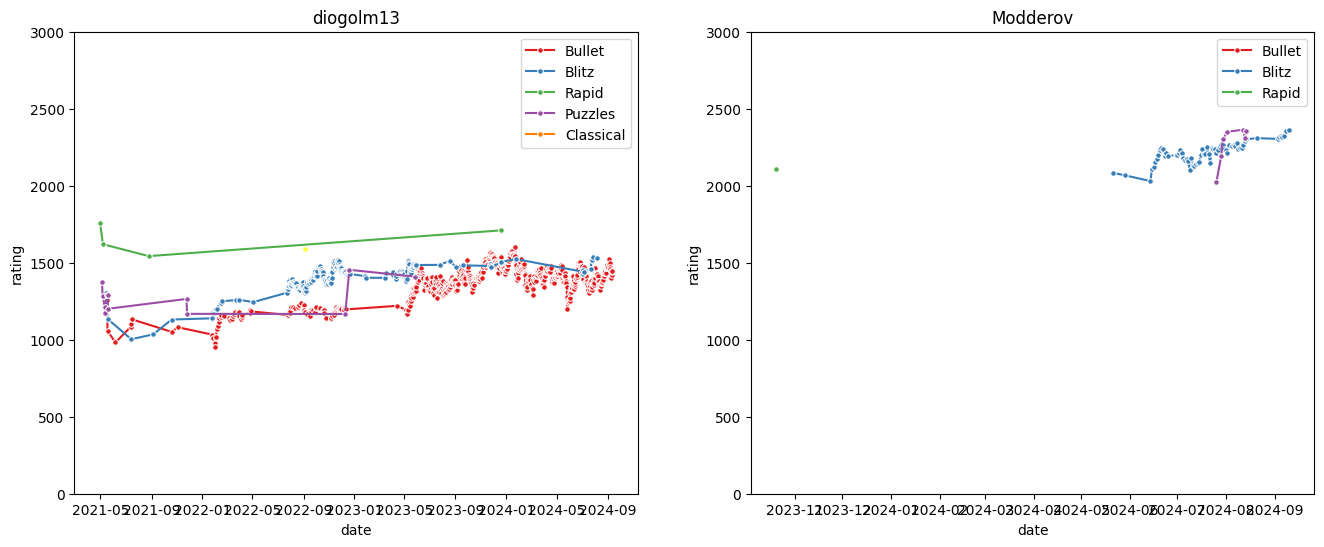

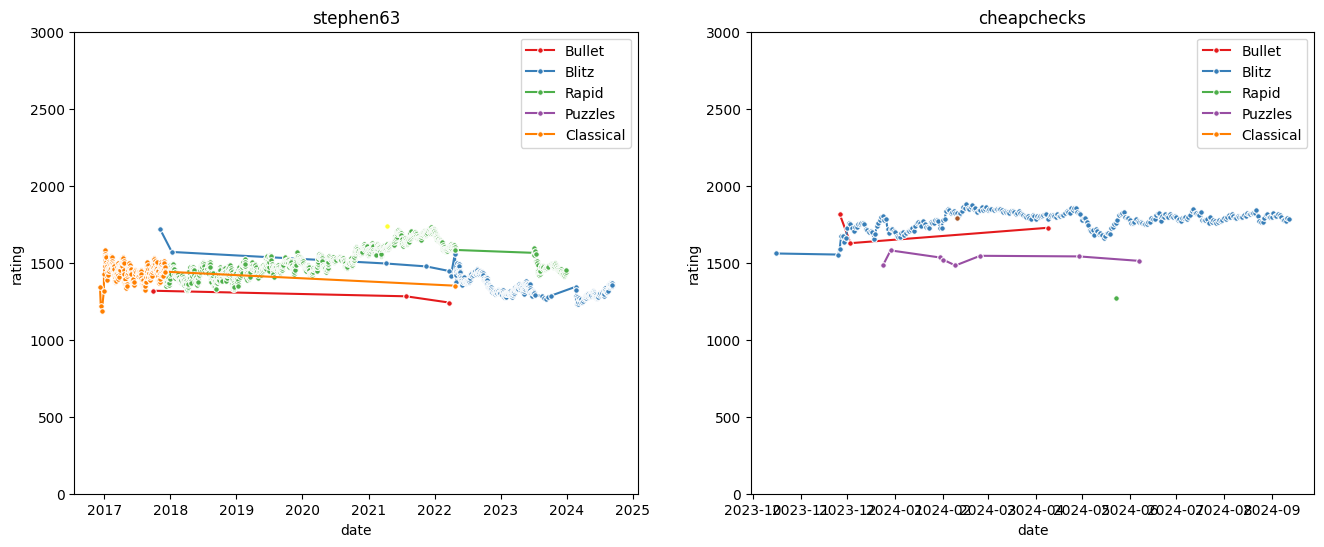

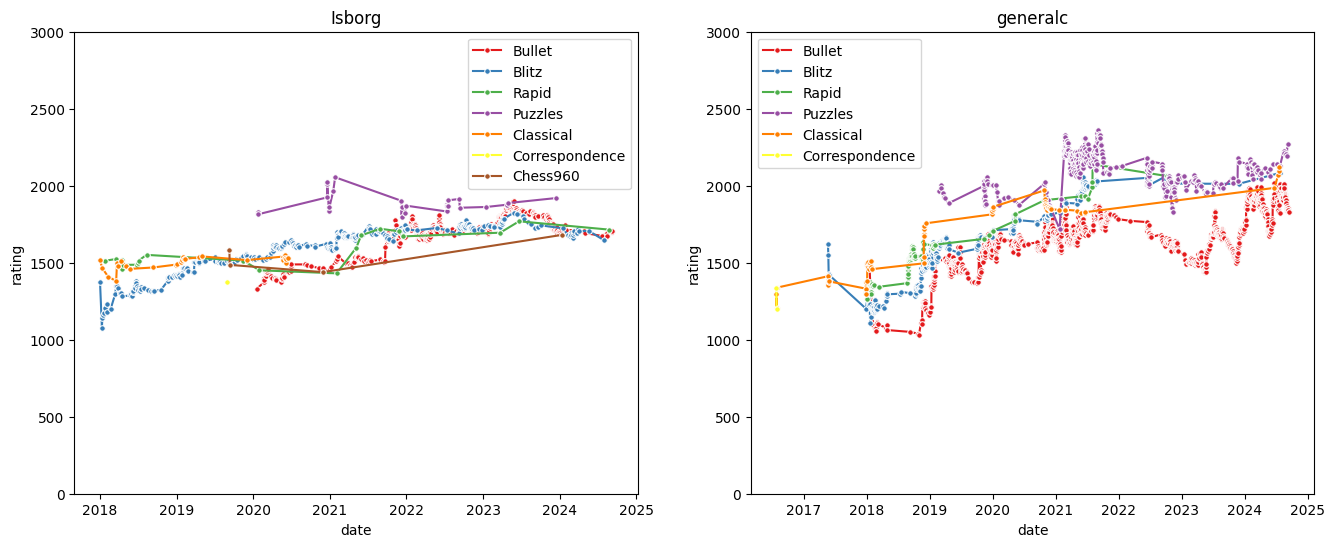

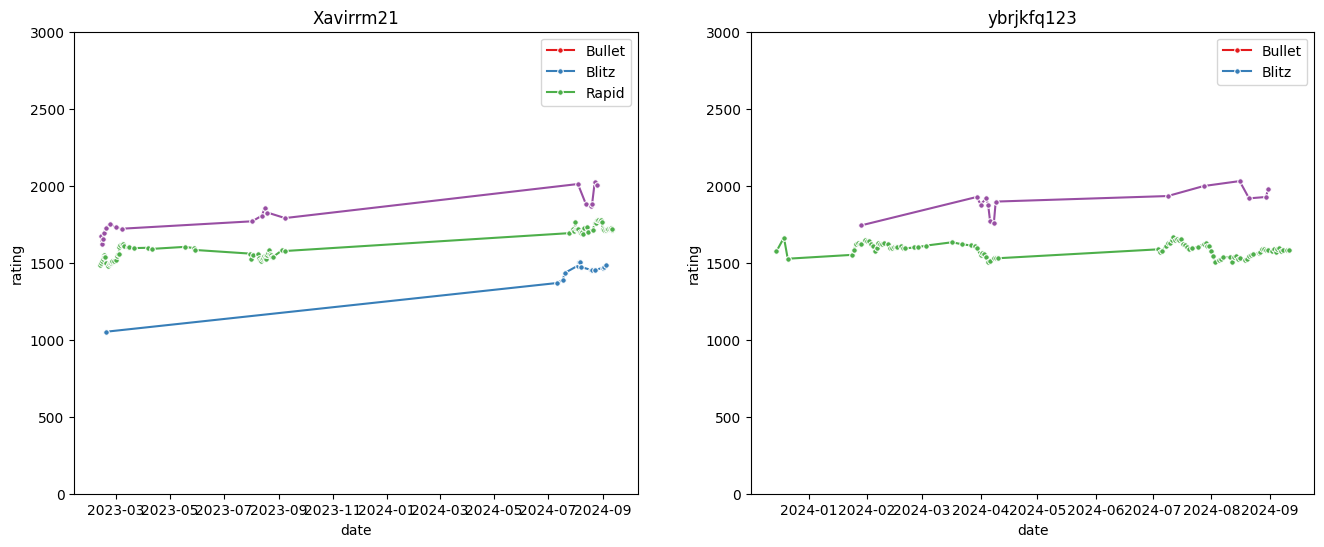

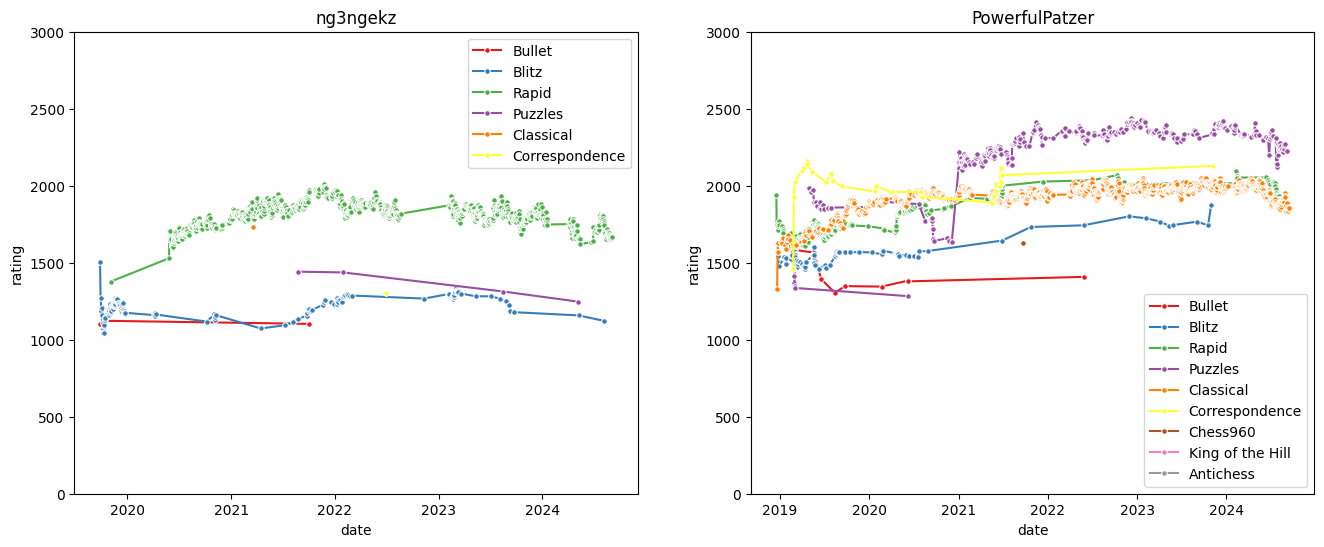

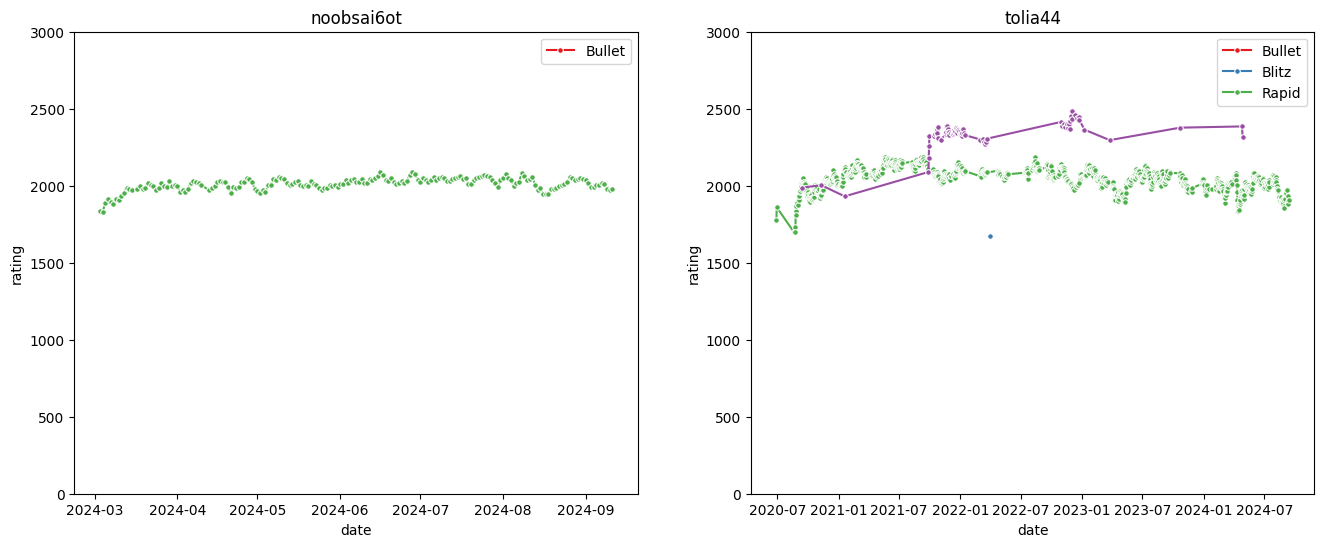

In [99]:
num_cols = 2
num_rows = 25
usernames = all_ratings["username"].unique()
sns.set_palette("Set1")
for i in range(num_rows):
    fig, ax = plt.subplots(1, num_cols, figsize=(16,6))
    for j, user in enumerate(usernames[i*num_cols:i*num_cols+num_cols]):
        subset = all_ratings[all_ratings['username'] == user]
        if subset.shape[0] > 20:
            # sort ratings by date:
            subset = subset.sort_values(by='date')
            sns.lineplot(
                subset, 
                x="date", 
                y="rating", 
                hue="mode", 
                hue_order=all_ratings["mode"].unique(), 
                palette="Set1",
                marker=".", 
                markersize= 8, 
                ax=ax[j])
            ax[j].set_title(user)
            ax[j].set_ylim((0,3000))
            occurring_modes = subset["mode"].unique()
            handles, labels = ax[j].get_legend_handles_labels()
            ax[j].legend(handles=handles[:len(occurring_modes)], labels=labels[:len(occurring_modes)])

    plt.show()